<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/DrugFinalReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ## 공학전산응용 최종 프로젝트
# *Seq2Seq FingerPrint : An Unsupervised Deep Molecular Embedding for Drug Discovery*

##### 팀장 : 김진욱, 팀원 : 신현승, 천희수


In [0]:
def DownloadRDkit():
  !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
  !chmod +x Miniconda3-latest-Linux-x86_64.sh
  !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
  !time conda install -q -y -c conda-forge rdkit

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # warining 표시 안나오도록 하기

In [0]:
DownloadRDkit() # RDkit 다운로드
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [0]:
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split

#### 이번 프로젝트 진행에서 이용한 데이터셋은 'GDB-11' 데이터이다. GDB-11 데이터셋은 REYMOND RESEARCH GROUP 에서<br> 발췌하였으며, 'C', 'O', 'N', 'F'. 'H' 의 원소들로 구성된 유기 분자들의 집합 데이터로, 이 데이터를 통해 모델링을 실행시켜보고<br> 약물 분야로서의 이용 가능성을 판단해볼 것이다.
<br>

> Reference  

Virtual exploration of the chemical universe up to 11 atoms of C, N, O, F: assembly of 26.4 million structures (110.9 million stereoisomers) and analysis for new ring systems, stereochemistry, physico-chemical properties, compound classes and drug discovery. Fink, T.; Reymond, J.-L. J. Chem. Inf. Model. 2007, 47, 342-353.

Virtual Exploration of the Small Molecule Chemical Universe below 160 Daltons. Fink, T.; Bruggesser, H.; Reymond, J.-L. Angew. Chem. Int. Ed. 2005, 44, 1504-1508.

In [91]:
smifile = "gdb11_size08.smi" # 데이터셋 받아오기
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
# delimiter는 구분자
from sklearn.model_selection import train_test_split # 훈련데이터 검증데이터 구분
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print (smiles_train.shape)
print (smiles_test.shape)

(50029,)
(16677,)


In [153]:
data.sample(10) # 데이터셋 샘플 확인

,smiles,No,Int
19753,CC=C(C)C(=C)CN,19754,1
2192,NC(=O)C#CC(N)=O,2193,3
17899,CNC(C)C(C)OC,17900,1
50320,CCOCC#CCO,50321,1
47050,CC(N)C1OCCO1,47051,1
48796,CCCCCCC#N,48797,1
62905,C1ON=C2N=CNC12,62906,3
40196,CN1OCC(F)C1=O,40197,1
48150,C1NCC12CNN=C2,48151,1
41507,CC1=C(C)C(=O)N=C1,41508,1


In [93]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5 # 23+5=28
print (str(charset))
print(len(charset), embed)
# len(charset) : smiles에 쓰이는 글자 개수, 아래 결과와 같이 22개

{'n', 'F', ']', '!', ')', '[', 'c', '-', 'o', '=', 'N', '4', '3', 'O', '+', 'E', '(', '2', '#', 'H', 'C', '1'}
22 28


In [94]:
print(char_to_int) # 문자에 부여된 인덱스 확인

{'n': 0, 'F': 1, ']': 2, '!': 3, ')': 4, '[': 5, 'c': 6, '-': 7, 'o': 8, '=': 9, 'N': 10, '4': 11, '3': 12, 'O': 13, '+': 14, 'E': 15, '(': 16, '2': 17, '#': 18, 'H': 19, 'C': 20, '1': 21}


In [95]:
print(int_to_char) # 인덱스로부터 문자 확인

{0: 'n', 1: 'F', 2: ']', 3: '!', 4: ')', 5: '[', 6: 'c', 7: '-', 8: 'o', 9: '=', 10: 'N', 11: '4', 12: '3', 13: 'O', 14: '+', 15: 'E', 16: '(', 17: '2', 18: '#', 19: 'H', 20: 'C', 21: '1'}


In [252]:
a=([len(smile) for smile in data.smiles])
aSet=set(a)
smiles_length=list(aSet) 
print(smiles_length) # 최대 길이가 23이므로 embed 길이는 28
# 아래 결과는 최대 길이 확인만을 위해 중복 항을 삭제하였음

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23]


##### charset 에는 smiles 데이터에 쓰이는 문자들과 시작과 끝을 나타내기 위한 !, E를 추가하였다.
##### 그 후 enumerate 함수를 통해 인덱스를 부여하였다. embed는 패딩처리를 할 길이로, smiles 데이터에서 최대 길이를 가지는 값을 찾아<br> 5를 더해주었다. 위의 !, E와 함께 데이터들은 !로 시작하여 1개 또는 여러 개의 E로 끝나는 형식을 가진다.<br> 즉, E가 길이가 28보다 작을 때 패딩 처리를 해준다.

N#CC#CC1COC1


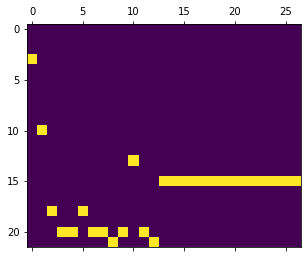

In [97]:
def vectorize(smiles):  
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print (smiles_train.iloc[0])
# iloc 함수는 순서를 나타내는 정수 기반의 2차원 인덱싱, 정확한 행/열 가져올 때 사용
# 행 번호를 기준으로 행 데이터를 읽음
plt.matshow(X_train[0].T)
#print X_train.shape

##### 위의 벡터는 N#CC#CC1C0C1 을 나타낸 것이다. 각 글자별 인덱스가 좌표에 노란 점으로 나타난다. !의 인덱스가 위에서 3, E의 인덱스가 위에서 15를 나타내므로 처음과 끝에 3, 15에 표현이 되는 것을 볼 수 있다. 15에 길게 나타나는 것은 패딩의 효과이다.

In [98]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
# 인덱스를 문자로 변환

'!N#CC#CC1COC1EEEEEEEEEEEEEE'

In [0]:
import tensorflow as tf

In [0]:
from tensorflow import keras

In [0]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # warining 표시 안나오도록 하기

In [0]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True, 
                unroll=unroll) # 상태정보만 출력
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
#  LSTM은 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.
states = Concatenate(axis=-1)([state_h, state_c])
# Concatenate 함수로 두 상태 배열을 연결
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states) # context 벡터

In [104]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs) # context 벡터 값을 넣어줌
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True, # 출력값도 사용함으로 True
                    unroll=unroll)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 한다.
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# 인코더, 디코더의 입력과 디코더의 결과를 평가하는 모델 생성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print (model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 27, 22)       0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 64), (None,  22272       input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 128)          0           lstm_5[0][1]                     
                                                                 lstm_5[0][2]                     
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           8256        concatenate_3[0][0]        

In [115]:
from keras.callbacks import History, ReduceLROnPlateau
h = History() # history는 fit 함수를 사용하는 과정에서 학습 이력 정보를 리턴
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
# verbose는 keras 학습 단계에서 진행 상태를 어떻게 표시할 것인지 설정
# (0이면 표시 안함, 1이면 진행 막대 표시, 2이면 에폭당 1개 줄 표시)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.optimizers import RMSprop, Adam # 최적화함수 설정
opt=Adam(lr=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [117]:
model.fit([X_train,X_train],Y_train, # 데이터셋 훈련
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ]) 

Train on 50029 samples, validate on 16677 samples
Epoch 1/100
50029/50029 [==============================] - 16s 328us/step - loss: 0.5618 - val_loss: 0.5747
Epoch 2/100
50029/50029 [==============================] - 17s 330us/step - loss: 0.5286 - val_loss: 0.4868
Epoch 3/100
50029/50029 [==============================] - 16s 327us/step - loss: 0.4765 - val_loss: 0.5062
Epoch 4/100
50029/50029 [==============================] - 16s 323us/step - loss: 0.4507 - val_loss: 0.4263
Epoch 5/100
50029/50029 [==============================] - 16s 325us/step - loss: 0.4080 - val_loss: 0.5994
Epoch 6/100
50029/50029 [==============================] - 16s 325us/step - loss: 0.3711 - val_loss: 0.3463
Epoch 7/100
50029/50029 [==============================] - 16s 327us/step - loss: 0.3315 - val_loss: 0.3216
Epoch 8/100
50029/50029 [==============================] - 16s 327us/step - loss: 0.2964 - val_loss: 0.2735
Epoch 9/100
50029/50029 [==============================] - 16s 326us/step - loss: 0.26

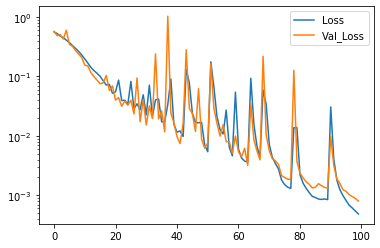

In [118]:
plt.plot(h.history["loss"], label="Loss") # 다소 튀는 현상이 있으나 감소하는 경향을 보임
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [0]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #  v는 softmax 함수의 출력값, 즉 확률을 담고 있음.
    idxs = np.argmax(v, axis=2) # v의 각 리스트에서 가장 큰 확률값의 위치들을 모아 idx변수 생성 
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    # idx의 index로 정수 파악하여 분자 나타냄
    idxs2 = np.argmax(X_test[i:i+1], axis=2) # 훈련데이터의 각 리스트에서 가장 큰 확률값의 위치들을 모아 idx변수 생성 
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:] # index로 정수 파악
    if true != pred: # 검증데이터가 훈련데이터와 같지 않으면 출력
        print (true, pred) # 훈련이 잘 되었음을 확인

In [120]:
print(v[0][0]) # 20번째 위치에서 가장 높은 확률을 나타냄

[3.0270786e-21 9.7755638e-08 3.4870845e-21 9.8487896e-17 2.3173785e-19
 1.2044871e-23 3.1522160e-11 2.8814344e-23 3.4412466e-19 3.6349776e-16
 2.4252734e-15 4.7510310e-21 9.3899546e-20 7.5870753e-17 1.2383065e-23
 5.9414490e-20 1.7558295e-17 1.7303318e-22 1.6952131e-16 3.6926949e-26
 9.9999988e-01 5.1380721e-20]


In [123]:
print(idxs) #앞에서 부여했던 인덱스로 정수를 찾아냄
print(str(pred))

[[20 20 20 16 20  4  9 10 10 20  9 10 15 15 15 15 15 15 15 15 15 15 15 15
  15 15 15]]
CCC(C)=NNC=NEEEEEEEEEEEEEE


In [124]:
print(str(true))

CCC(C)=NNC=NEEEEEEEEEEEEEE


##### 훈련된 자동 인코더의 일부를 사용하여 다양한 인코더 및 디코더 모델을 만들 수 있다. 인코더 모델에서의 입력과 출력을 재사용하여 context 벡터를 만드는 모델, smiles_to_latent_model은 앞에서의 인코더 입력과, 은닉상태 및 셀 상태로 이루어진 결과, 즉 훈련된 결과를 이용한 모델이므로 별다른 훈련이 필요하지 않다.

In [0]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
# 인코더 입력으로 나온 상태 값들로 context벡터 생성

##### context 벡터의 상태를 디코더로 전달하는 latent_to_states_model을 만들어 보자.

In [0]:
latent_input = Input(shape=(latent_dim,)) 
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])

![seq2seq base 구조2](https://user-images.githubusercontent.com/52277776/70389270-6f6da400-1a00-11ea-922d-c159dc517cc9.png)

##### 이번에는 상태 유지(stateful) 모델에 대해서 알아보자. 이는 현재 학습된 상태가 다음 학습시 초기 상태로 전달된다는 것을 의미한다.

##### 기존 모델이 이전 타임스텝의 상태를 현재 타임 스텝에 이용하였다면, 상태유지 모델은 한 배치 내 샘플의 상태를 계산하여, <br>이 값을 다음 배치 내 샘플의 초기 상태로 재사용한다는 의미이다. 조금 더 간단히 말하면, '타입스템간 상태 전이'와 '샘플간 상태 전이'의 차이이다.

##### 긴 시퀀스 데이터를 처리할 때, LSTM 모델은 상태유지 모드에서 그 진가를 발휘한다. 긴 시퀀스 데이터를 샘플 단위로 잘라서 학습하더라도 LSTM 내부적으로 기억할 것은 기억하고 버릴 것은 버려서 기억해야할 중요한 정보만 이어갈 수 있도록 상태가 유지되기 때문이다. 상태유지 LSTM 모델을 생성하기 위해서는 LSTM 레이어 생성 시, stateful=True로 설정하면 된다. 또한 상태유지 모드에서는 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정해야 한다. 기본적으로 상태유지 모드에서는 배치사이즈를 1로 설정한다. 한 샘플을 학습한 후 그 상태를 다음 샘플 학습 시에 전달하기 위해서이다.

In [0]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True) # stateful 적용하는 점만 달라짐
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [129]:
# 인코더로부터의 가중치를 전달
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (1, 1, 22)                0         
_________________________________________________________________
lstm_8 (LSTM)                (1, 1, 64)                22272     
_________________________________________________________________
dense_12 (Dense)             (1, 1, 22)                1430      
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


##### context 벡터(앞에서 언급했던 latent space)는 인코더로부터의 정보들을 통해 연관성을 파악하는데 도움을 줄 수 있다.

##### 유사한 분자가 유사한 벡터를 생성하는지 보기 위해 탐색을 진행해보자. 여기서 context vector의 차이는 유사성의 측정 지표로 이용된다.

In [0]:
x_latent = smiles_to_latent_model.predict(X_test)

[    5 15472  1243 14589 15039 15257 12643 13509  3383 11812]
45051      COCc1cocn1
45061      COCc1conn1
45007      COCc1ccoc1
44719      COCc1ccno1
45069      COCc1ncon1
43078      COCCC1CCO1
57988      COc1cocc1C
35002    COc1coc(O)n1
Name: smiles, dtype: object


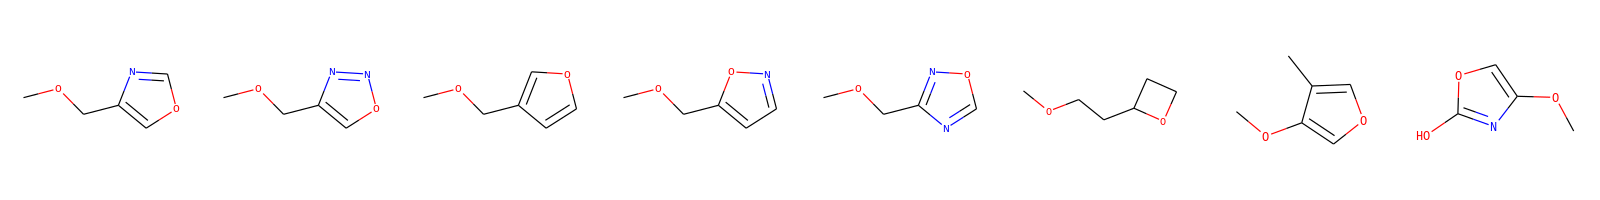

In [145]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
# 차이를 측정 지표로 오름차순으로 정렬(차이가 작을수록 유사)
print (sorti[0:10]) # 가장 비슷하다고 판단되는 10개 출력
print (smiles_test.iloc[sorti[0:8]]) # 차이에 대한 행번호를 읽어 test 데이터에서 읽음
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

In [160]:
smiles_test[4:6] # 5번째 행 확인

64401    O1C=CC2OC2C=C1
45051        COCc1cocn1
Name: smiles, dtype: object

In [162]:
smiles_test[1242:1244] # 1243번째 행 확인

42972    O=C(C#C)C1CNC1
45007        COCc1ccoc1
Name: smiles, dtype: object

##### 그러나 위의 결괏값들은 우리가 원하는 분자의 유사성보다는 단지 구조의 유사성으로 인한 결과일 수 있다. 가장 다른 분자가 무엇인지 알아보자.

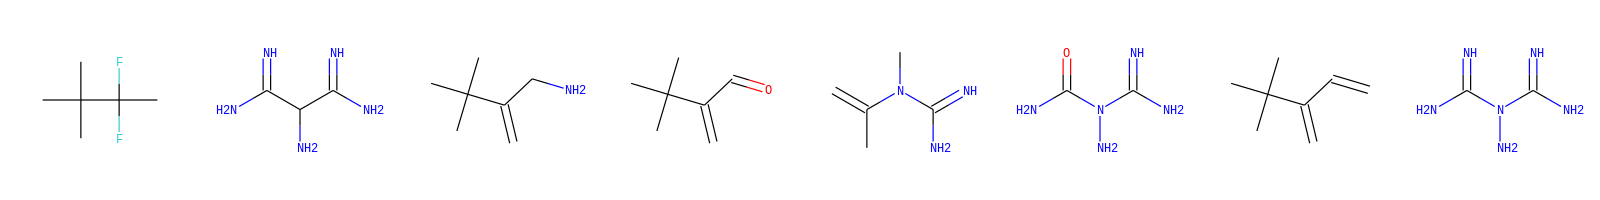

In [140]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))
# 오름차순으로 정렬한 sorti에서 마지막에서 거꾸로 읽음(가장 차이 큰 8개)

##### 화학적 특성 비교를 위해 계산된 MR(몰 굴절지수)과 lop P(분배계수) 값이 PCA(데이터의 분산을 나타냄)에 어떻게 나타는지 확인해 보자.  

In [0]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.309977   0.15513627] 0.46511328


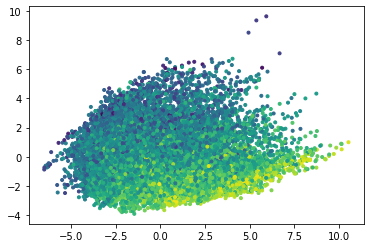

In [142]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))
# lopP에 대한 결과

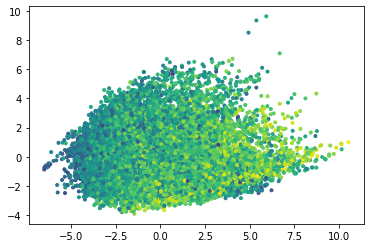

In [143]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)
# MR에 대한 결과

##### 다음으로는 logP 를 인자로 하여 인코더 입력을 받아 context vector가 예측한 log P와 실제 스마일 데이터로 얻은 log P를 비교해볼 것이다. 

In [0]:
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

In [0]:
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

In [165]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=400, callbacks = [rlr])

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/400
50029/50029 [==============================] - 2s 37us/step - loss: 0.3384
Epoch 2/400
 7552/50029 [===>..........................] - ETA: 0s - loss: 0.2805

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50029/50029 [==============================] - 1s 22us/step - loss: 0.2677
Epoch 3/400
50029/50029 [==============================] - 1s 22us/step - loss: 0.2455
Epoch 4/400
50029/50029 [==============================] - 1s 22us/step - loss: 0.2305
Epoch 5/400
50029/50029 [==============================] - 1s 23us/step - loss: 0.2198
Epoch 6/400
50029/50029 [==============================] - 1s 22us/step - loss: 0.2098
Epoch 7/400
50029/50029 [==============================] - 1s 24us/step - loss: 0.2023
Epoch 8/400
50029/50029 [==============================] - 1s 23us/step - loss: 0.1930
Epoch 9/400
50029/50029 [==============================] - 1s 23us/step - loss: 0.1890
Epoch 10/400
50029/50029 [==============================] - 1s 23us/step - loss: 0.1857
Epoch 11/400
50029/50029 [==============================] - 1s 24us/step - loss: 0.1819
Epoch 12/400
50029/50029 [==============================] - 1s 23us/step - loss: 0.1778
Epoch 13/400
50029/50029 [==========================

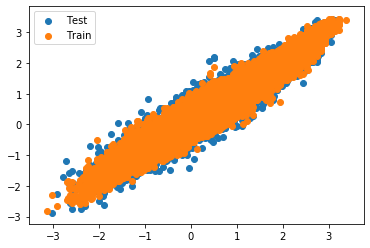

In [166]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

##### 위와 같이 얻어낸 그래프 형태는 QSAR 모델(구조-활성의 정량적 관계)에서 나타나는 그래프 형태와 유사하다. 따라서 우리가 설계한 신경망 모델이 QSAR 모델에도 적용 가능하다고 판단하였다. QSAR은 실제로 어떠한 물질의 독성예측 및 신약개발을 위해서 사용된다.

![QSAR](https://user-images.githubusercontent.com/52277776/70991425-c4996c00-210a-11ea-9cfc-f51d2a9ca134.PNG)

##### latent space, 간단히 말해서 context 벡터를 디코더에 적용하기 위해서, 두가지 단계가 필요하다. <br>첫 번째는 디코더의 LSTM 구조의 초깃값으로 은닉상태와 셀 상태를 입력시키기 위해 latent_to_smiles 함수를 사용할 것이다.<br>두 번째로 초반부에 마지막에 입력시켜주었던 'E'가 나올 때까지 진행한다.

In [0]:
def latent_to_smiles(latent):
    # 디코더로 상태를 전달하는 latent_to_states_model 이용
    states = latent_to_states_model.predict(latent)
    # 초기상태 설정
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    startidx = char_to_int["!"] # 시작을 의미하는 !의 인덱스 3을 시작 인덱스로 설정
    samplevec = np.zeros((1,1,22))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28): # 최대 길이가 28이었으므로 28까지로 설정
        o = sample_model.predict(samplevec) #sample 벡터를 예측함수에 입력
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E": # E가 될 때까지 찾은 글자를 정수화 해서 붙임
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22)) # samplevec 다시 초기화
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [169]:
smiles = latent_to_smiles(x_latent[0:1]) 
print (smiles) # 위 모델의 결과 확인
print (smiles_test.iloc[0]) # 타깃데이터에서 값 출력

NCCC1OC=NO1
NCCC1OC=NO1


##### 위 방법으로 테스트 세트를 얻어낼 때 잘못 형성된 SMILES의 분율이 얼마나 되는지 알 수 있다.

In [172]:
# 정확도 확인
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles) # smiles 규칙 적용
    if mol: # smiles 법칙에 어긋나지 않을 때
        pass
    else: # 잘못 형성된 구조일 때
        print (smiles)
        wrong = wrong + 1
print ("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))
# 잘못 형성된 게 없음을 확인.

0.0 percent wrongly formatted smiles


###### 여기서 context vector의 내재되어 있는 smiles 구조를 확인해봄으로써 중요한 사실을 도출해낼 수 있다.

##### 아래 그림은 context vector 내부를 간단히 표현해본 것이다.<br>그림에서 말하고자 하는 것은 상태 1과 상태 2가 있을 때 두 상태 사이의 상태들이 연속적이라는 것이다.<br> 즉, 상태들의 연관성에 따라서 나열되어 있다는 것이다. 

![interpoled](https://user-images.githubusercontent.com/52277776/70995826-ccf6a480-2114-11ea-90eb-5c069b2e836d.PNG)

In [0]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

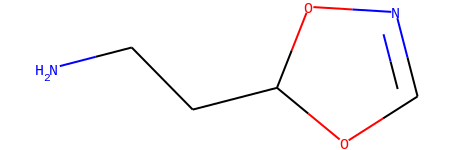

In [248]:
Chem.MolFromSmiles('NCCC1OC=NO1')

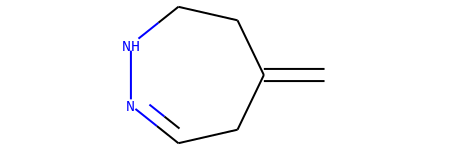

In [250]:
Chem.MolFromSmiles('C=C1CCNN=CC1')

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # warining 표시 안나오도록 하기

RDKit ERROR: [13:27:32] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [13:27:32] Explicit valence for atom # 4 O, 3, is greater than permitted


NCCC1=OCNO1
NCCC1=OCNN1


RDKit ERROR: [13:27:32] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [13:27:32] Explicit valence for atom # 7 O, 3, is greater than permitted


CC1O(CO)NN1C
C=CNC1CNC=O1


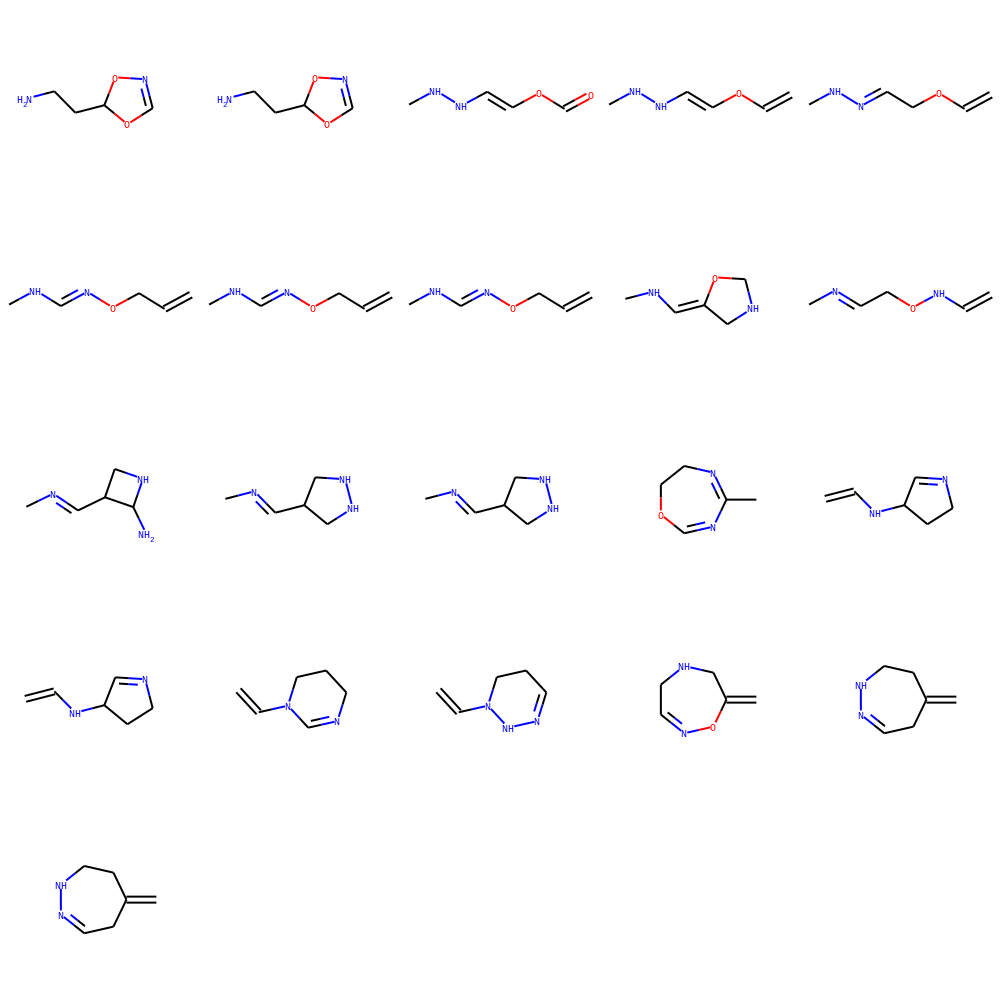

In [257]:
# 위의 두 분자 사이 인덱스에 존재하는 분자들 나열
i = 0
j= 2
latent1 = x_latent[j:j+1] # 상태 1
latent0 = x_latent[i:i+1] # 상태 2
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    # r 값에 따라 순차적으로 상태 1부터 상태 2까지 smiles 규칙성에 맞는 분자 출력
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print (smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

##### 위 결과로부터 두 상태 사이의 존재하는 상태들을 통해 비슷한 구조를 가지는 분자들은 context vector 내에서 아주 근접하게 위치해 있다는 것을 확인할 수 있다. 이 사실을 통해 개별의 분자들이 연속적인 공간에 위치해 있다는 것을 알 수 있다. 

> ### 고찰
#### 지금까지 LSTM 기반의 인코더를 만드는 방법과 교사 강제를 통해서 효과적으로 훈련시키는 과정을 진행하였다. 여기서 모델링한 latent space, 즉 context vector는 SMILES의 구조를 반영하고, 화학구조 파악이 요구되는 작업에 매우 효과적이라고 할 수 있다. context vector 내부의 분자들의 연속적인 공간에서의 배열을 확인함으로써, context vector 가 입력된 분자들에 대해서 연관성을 반영한다는 점을 확인하였다. 이는 앞에서 언급하였던 QSAR 모델과 같은 예와 같이 약물 분야로의 이용 가능성을 확장시켜 약물 치료에 효과적으로 이용될 수 있는 모델이라고 판단된다.